# 1. Install YOLOv8

In [1]:
!pip install ultralytics opencv-python matplotlib

# Install the COCO dataset

In [29]:
!pip install pycocotools

# 2. Import Libraries

In [2]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\HP\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# 3. Load YOLOv8 pose model (pretrained on COCO Keypoints)

In [3]:
model = YOLO("yolov8n-pose.pt")  # small + fast

# 5. Run Inference

In [6]:
results = model(img_rgb)

# Print summary
for r in results:
    print(r.keypoints)   # 17 COCO keypoints


0: 640x480 4 persons, 161.1ms
Speed: 13.0ms preprocess, 161.1ms inference, 42.3ms postprocess per image at shape (1, 3, 640, 480)
ultralytics.engine.results.Keypoints object with attributes:

conf: tensor([[0.9817, 0.9162, 0.9677, 0.5038, 0.8512, 0.9872, 0.9921, 0.9387, 0.9747, 0.9001, 0.9523, 0.9957, 0.9968, 0.9916, 0.9944, 0.9642, 0.9726],
        [0.9734, 0.9192, 0.9536, 0.6233, 0.8177, 0.9849, 0.9878, 0.9037, 0.9323, 0.8472, 0.8893, 0.9916, 0.9924, 0.9862, 0.9885, 0.9564, 0.9606],
        [0.0685, 0.0638, 0.0235, 0.1380, 0.0357, 0.2755, 0.1462, 0.2936, 0.1130, 0.3032, 0.1533, 0.4404, 0.3462, 0.6252, 0.5275, 0.5319, 0.4732],
        [0.0857, 0.0526, 0.0392, 0.0874, 0.0645, 0.4026, 0.1571, 0.4728, 0.1442, 0.4888, 0.2098, 0.3740, 0.2327, 0.3328, 0.1992, 0.2097, 0.1410]])
data: tensor([[[1.4295e+02, 4.4113e+02, 9.8174e-01],
         [1.4923e+02, 4.3267e+02, 9.1625e-01],
         [1.3296e+02, 4.3263e+02, 9.6772e-01],
         [1.5492e+02, 4.3891e+02, 5.0382e-01],
         [1.0884e+02, 

# 6. Visualize Keypoints

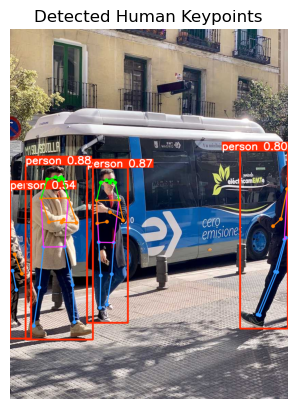

In [7]:
# YOLOv8 already provides plotting
results[0].plot()
plt.imshow(results[0].plot())
plt.axis("off")
plt.title("Detected Human Keypoints")
plt.show()

# 7. Extract 17 Keypoint Coordinates

In [8]:
keypoints = results[0].keypoints.xy[0].cpu().numpy()  # shape (17,2)
print("Keypoints:", keypoints)

Keypoints: [[     142.95      441.13]
 [     149.23      432.67]
 [     132.96      432.63]
 [     154.92      438.91]
 [     108.84      438.05]
 [     169.83      493.08]
 [     90.127      494.22]
 [     193.97      565.82]
 [      113.4      563.47]
 [      150.8      564.61]
 [     156.97       556.6]
 [     159.62      635.13]
 [     97.701      636.29]
 [     182.38      747.24]
 [     85.821      754.98]
 [     187.86      855.23]
 [     69.112      866.81]]


# Part 2: Model Integration into ROS2

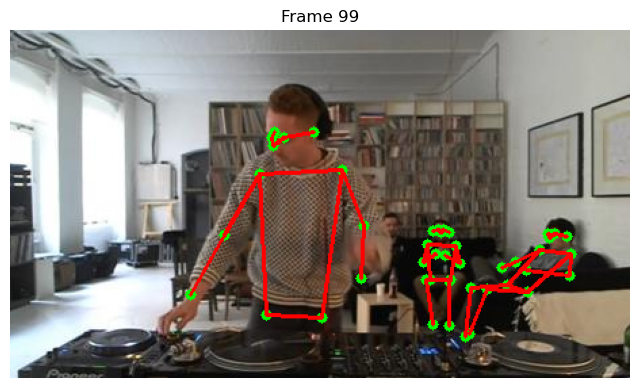

Frame 99: /human_pose keypoints length = 153


In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from pathlib import Path
from ultralytics import YOLO

# --- Helper function to draw keypoints and skeleton ---
def draw_on_image(frame, keypoints_list, conf_thresh=0.3):
    skeleton = [
        (0,1),(0,2),(1,3),(2,4),(5,6),(5,7),(7,9),(6,8),(8,10),
        (5,11),(6,12),(11,12),(11,13),(12,14),(13,15),(14,16)
    ]
    
    for kp in keypoints_list:
        for idx in range(kp.shape[0]):
            # Access each element explicitly to ensure scalars
            x = float(kp[idx,0])
            y = float(kp[idx,1])
            conf = float(kp[idx,2])
            
            if conf > conf_thresh:
                cv2.circle(frame, (int(x), int(y)), 4, (0,255,0), -1)
        
        for i, j in skeleton:
            if float(kp[i,2]) > conf_thresh and float(kp[j,2]) > conf_thresh:
                cv2.line(frame, 
                         (int(kp[i,0]), int(kp[i,1])), 
                         (int(kp[j,0]), int(kp[j,1])), 
                         (0,0,255), 2)
    return frame

# --- Pose Estimation Node ---
class PoseEstimationNode:
    """
    YOLOv8-Pose Node in Jupyter Notebook.
    - Processes frames from a folder
    - Stores keypoints
    - Visualizes skeleton in real-time
    """
    def __init__(self, model, conf_thresh=0.3):
        self.model = model
        self.conf_thresh = conf_thresh
        self.keypoints_log = []

    def process_frame(self, frame, frame_id=None, show=True):
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = self.model.predict(rgb, imgsz=640, conf=self.conf_thresh, iou=0.45, verbose=False)
        res = results[0]
        keypoints_array = []
        keypoints_list = []

        # CORRECTED LOGIC: Handle multiple person detections
        if hasattr(res, 'keypoints') and res.keypoints.data.numel() > 0:
            # The keypoints tensor has shape (num_persons, 17, 3)
            all_persons_keypoints = res.keypoints.data.cpu().numpy()
            
            # Iterate through each detected person
            for person_keypoints in all_persons_keypoints:
                # person_keypoints now has the expected shape (17, 3)
                keypoints_list.append(person_keypoints)
                keypoints_array.extend(person_keypoints.flatten().tolist())

        # Store keypoints
        self.keypoints_log.append({'frame_id': frame_id, 'keypoints': keypoints_array})

        # Visualization
        if show and keypoints_list:
            annotated = draw_on_image(frame.copy(), keypoints_list, conf_thresh=self.conf_thresh)
            clear_output(wait=True)
            plt.figure(figsize=(8,6))
            plt.axis('off')
            plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
            plt.title(f"Frame {frame_id}")
            plt.show()

        return keypoints_array

# --- Load YOLOv8-Pose model ---
model = YOLO("yolov8n-pose.pt")  # Automatically downloads if not present

# --- Initialize Pose Node ---
pose_node = PoseEstimationNode(model, conf_thresh=0.3)

# --- Path to folder of frames ---
folder_path = Path(r"E:\3Bz7y9kjlUc")  # Replace with your folder path

# --- Process images sequentially ---
frame_idx = 0
for img_path in sorted(folder_path.glob("*.jpg")):
    frame = cv2.imread(str(img_path))
    if frame is None:
        print(f"Failed to read {img_path}")
        continue
    keypoints = pose_node.process_frame(frame, frame_id=frame_idx, show=True)
    print(f"Frame {frame_idx}: /human_pose keypoints length = {len(keypoints)}")
    frame_idx += 1

# Part 3: Simulation Environment Setup

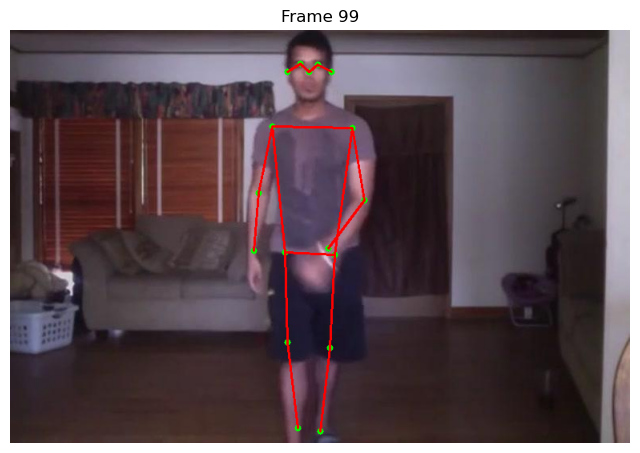

Frame 99: /human_pose keypoints length = 51
Keypoints saved to human_pose_keypoints.csv


In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from pathlib import Path
from ultralytics import YOLO
import csv

# --- Helper function to draw skeleton ---
def draw_on_image(frame, keypoints_list, conf_thresh=0.3):
    skeleton = [
        (0,1),(0,2),(1,3),(2,4),(5,6),(5,7),(7,9),(6,8),(8,10),
        (5,11),(6,12),(11,12),(11,13),(12,14),(13,15),(14,16)
    ]
    for kp in keypoints_list:
        for idx in range(kp.shape[0]):
            x = float(kp[idx,0])
            y = float(kp[idx,1])
            conf = float(kp[idx,2])
            if conf > conf_thresh:
                cv2.circle(frame, (int(x), int(y)), 4, (0,255,0), -1)
        for i,j in skeleton:
            if float(kp[i,2])>conf_thresh and float(kp[j,2])>conf_thresh:
                cv2.line(frame, (int(kp[i,0]), int(kp[i,1])),
                         (int(kp[j,0]), int(kp[j,1])), (0,0,255), 2)
    return frame

# --- Pose Estimation Node Simulation ---
class PoseEstimationNodeSim:
    def __init__(self, model, conf_thresh=0.3):
        self.model = model
        self.conf_thresh = conf_thresh
        self.keypoints_log = []

    def process_frame(self, frame, frame_id=None, show=True):
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = self.model.predict(rgb, imgsz=640, conf=self.conf_thresh, iou=0.45, verbose=False)
        res = results[0]
        keypoints_array = []
        keypoints_list = []

        if hasattr(res, 'keypoints') and res.keypoints.data.numel()>0:
            all_persons_keypoints = res.keypoints.data.cpu().numpy()
            for person_kp in all_persons_keypoints:
                keypoints_list.append(person_kp)
                keypoints_array.extend(person_kp.flatten().tolist())

        self.keypoints_log.append({'frame_id': frame_id, 'keypoints': keypoints_array})

        # Visualization
        if show and keypoints_list:
            annotated = draw_on_image(frame.copy(), keypoints_list, conf_thresh=self.conf_thresh)
            clear_output(wait=True)
            plt.figure(figsize=(8,6))
            plt.axis('off')
            plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
            plt.title(f"Frame {frame_id}")
            plt.show()

        return keypoints_array

# --- Load model ---
model = YOLO("yolov8n-pose.pt")

# --- Initialize simulated node ---
pose_node = PoseEstimationNodeSim(model, conf_thresh=0.3)

# --- Folder of frames (simulate camera subscription) ---
folder_path = Path(r"E:\4TXF5Z0JJEs")  # Replace with your frames folder
frame_idx = 0
keypoints_csv = []

# --- Process images sequentially ---
for img_path in sorted(folder_path.glob("*.jpg")):
    frame = cv2.imread(str(img_path))
    if frame is None:
        print(f"Failed to read {img_path}")
        continue
    keypoints = pose_node.process_frame(frame, frame_id=frame_idx, show=True)
    
    # Simulate publishing: log to CSV
    keypoints_csv.append([frame_idx] + keypoints)
    print(f"Frame {frame_idx}: /human_pose keypoints length = {len(keypoints)}")
    frame_idx += 1

# --- Save all keypoints to CSV ---
csv_path = Path("human_pose_keypoints.csv")
with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    for row in keypoints_csv:
        writer.writerow(row)

print(f"Keypoints saved to {csv_path}")

# Part 4: Real-Time Pose Detection in Simulation

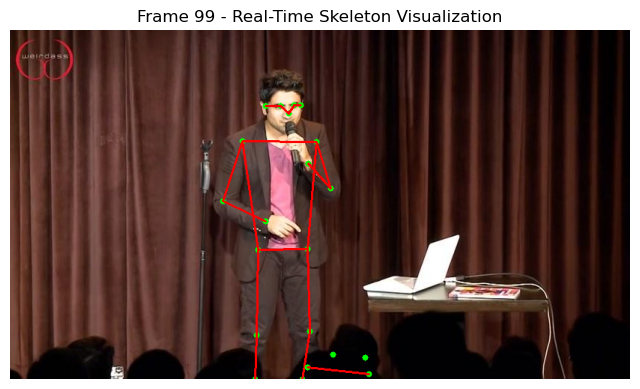

Real-Time Skeleton Visualization Complete!


In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from pathlib import Path
from ultralytics import YOLO
import time

# --- Helper to draw keypoints and skeleton ---
def draw_skeleton(frame, keypoints_list, conf_thresh=0.3):
    skeleton = [
        (0,1),(0,2),(1,3),(2,4),(5,6),(5,7),(7,9),(6,8),(8,10),
        (5,11),(6,12),(11,12),(11,13),(12,14),(13,15),(14,16)
    ]
    for kp in keypoints_list:
        for idx in range(kp.shape[0]):
            x, y, conf = float(kp[idx,0]), float(kp[idx,1]), float(kp[idx,2])
            if conf > conf_thresh:
                cv2.circle(frame, (int(x), int(y)), 4, (0,255,0), -1)
        for i, j in skeleton:
            if float(kp[i,2])>conf_thresh and float(kp[j,2])>conf_thresh:
                cv2.line(frame, (int(kp[i,0]), int(kp[i,1])),
                         (int(kp[j,0]), int(kp[j,1])), (0,0,255), 2)
    return frame

# --- Real-time Pose Visualizer ---
class PoseVisualizer:
    def __init__(self, model, conf_thresh=0.3):
        self.model = model
        self.conf_thresh = conf_thresh

    def process_frame(self, frame):
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = self.model.predict(rgb, imgsz=640, conf=self.conf_thresh, iou=0.45, verbose=False)
        keypoints_list = []
        res = results[0]
        if hasattr(res, 'keypoints') and res.keypoints.data.numel()>0:
            all_persons = res.keypoints.data.cpu().numpy()
            for person_kp in all_persons:
                keypoints_list.append(person_kp)
        return keypoints_list

# --- Load YOLOv8-Pose model ---
model = YOLO("yolov8n-pose.pt")
visualizer = PoseVisualizer(model)

# --- Simulate camera feed from frames folder ---
frames_path = Path(r"E:\9KSpndERzNU")  # folder with frame images
for idx, img_path in enumerate(sorted(frames_path.glob("*.jpg"))):
    frame = cv2.imread(str(img_path))
    if frame is None:
        continue
    keypoints_list = visualizer.process_frame(frame)
    annotated = draw_skeleton(frame.copy(), keypoints_list)
    
    # Display frame in notebook
    clear_output(wait=True)
    plt.figure(figsize=(8,6))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {idx} - Real-Time Skeleton Visualization")
    plt.show()
    
    time.sleep(0.1)  # simulate ~10 FPS

print("Real-Time Skeleton Visualization Complete!")

# Part 5: Application Scenario

# Example 1: If both hands are raised (arms up), trigger a robot response (e.g., stop movement)

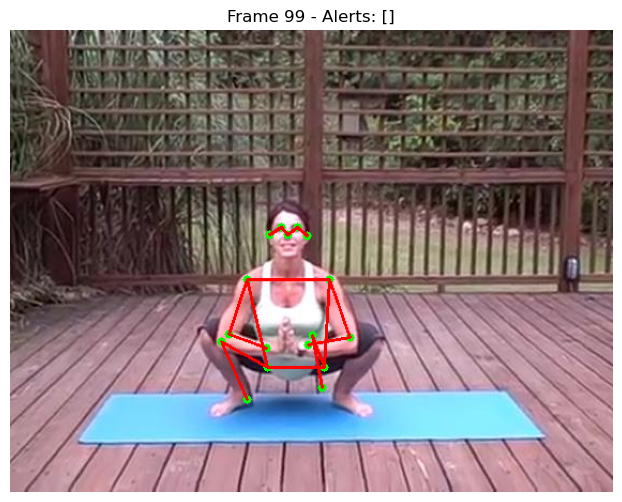

In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from pathlib import Path
from ultralytics import YOLO
import time

# --- Helper to draw skeleton ---
def draw_skeleton(frame, keypoints_list, conf_thresh=0.3):
    skeleton = [
        (0,1),(0,2),(1,3),(2,4),(5,6),(5,7),(7,9),(6,8),(8,10),
        (5,11),(6,12),(11,12),(11,13),(12,14),(13,15),(14,16)
    ]
    for kp in keypoints_list:
        for idx in range(kp.shape[0]):
            x, y, conf = float(kp[idx,0]), float(kp[idx,1]), float(kp[idx,2])
            if conf > conf_thresh:
                cv2.circle(frame, (int(x), int(y)), 4, (0,255,0), -1)
        for i, j in skeleton:
            if float(kp[i,2])>conf_thresh and float(kp[j,2])>conf_thresh:
                cv2.line(frame, (int(kp[i,0]), int(kp[i,1])),
                         (int(kp[j,0]), int(kp[j,1])), (0,0,255), 2)
    return frame

# --- Hands-up detection (Example 1) ---
def detect_hands_up(keypoints_list):
    alerts = []
    for kp in keypoints_list:
        head_y = kp[0,1]
        left_wrist_y = kp[9,1]
        right_wrist_y = kp[10,1]
        if left_wrist_y < head_y and right_wrist_y < head_y:
            alerts.append("Hands Raised → STOP")
    return alerts

# --- Pose system ---
class PoseSystem:
    def __init__(self, model, conf_thresh=0.3):
        self.model = model
        self.conf_thresh = conf_thresh

    def process_frame(self, frame):
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = self.model.predict(rgb, imgsz=640, conf=self.conf_thresh, iou=0.45, verbose=False)
        keypoints_list = []
        res = results[0]
        if hasattr(res, 'keypoints') and res.keypoints.data.numel() > 0:
            all_persons = res.keypoints.data.cpu().numpy()
            for person_kp in all_persons:
                keypoints_list.append(person_kp)
        return keypoints_list

# --- Load YOLOv8-Pose ---
model = YOLO("yolov8n-pose.pt")
system = PoseSystem(model)

# --- Simulate camera feed ---
frames_path = Path(r"E:\Xukpu9Ls3As")  # folder of frames
for idx, img_path in enumerate(sorted(frames_path.glob("*.jpg"))):
    frame = cv2.imread(str(img_path))
    if frame is None:
        continue

    keypoints_list = system.process_frame(frame)
    annotated = draw_skeleton(frame.copy(), keypoints_list)
    alerts = detect_hands_up(keypoints_list)

    # Display skeleton and alerts
    clear_output(wait=True)
    plt.figure(figsize=(8,6))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {idx} - Alerts: {alerts}")
    plt.show()
    
    if alerts:
        print("Robot Triggered Responses:", alerts)

    time.sleep(0.1)  # simulate ~10 FPS

# Example 2: If a person falls (e.g., low hip and head position), publish an emergency flag

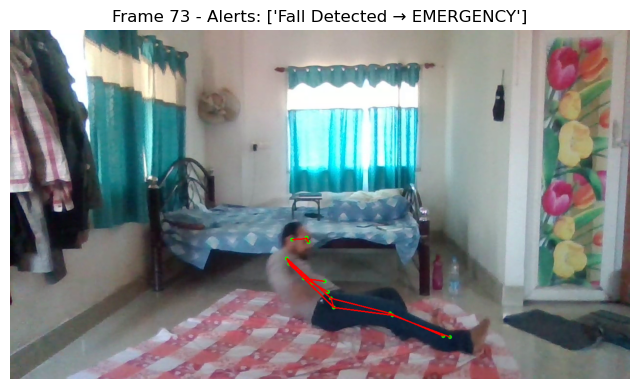

Robot Triggered Responses: ['Fall Detected → EMERGENCY']


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from ultralytics import YOLO
import time

# --- Helper to draw skeleton ---
def draw_skeleton(frame, keypoints_list, conf_thresh=0.3):
    skeleton = [
        (0,1),(0,2),(1,3),(2,4),(5,6),(5,7),(7,9),(6,8),(8,10),
        (5,11),(6,12),(11,12),(11,13),(12,14),(13,15),(14,16)
    ]
    for kp in keypoints_list:
        for idx in range(kp.shape[0]):
            x, y, conf = float(kp[idx,0]), float(kp[idx,1]), float(kp[idx,2])
            if conf > conf_thresh:
                cv2.circle(frame, (int(x), int(y)), 4, (0,255,0), -1)
        for i, j in skeleton:
            if float(kp[i,2]) > conf_thresh and float(kp[j,2]) > conf_thresh:
                cv2.line(frame, (int(kp[i,0]), int(kp[i,1])),
                         (int(kp[j,0]), int(kp[j,1])), (0,0,255), 2)
    return frame

# --- Fall detection behavior ---
def detect_fall(keypoints_list, hip_threshold=400, head_threshold=300):
    alerts = []
    for kp in keypoints_list:
        head_y = kp[0,1]
        hip_y = (kp[11,1] + kp[12,1]) / 2
        if hip_y > hip_threshold and head_y > head_threshold:
            alerts.append("Fall Detected → EMERGENCY")
    return alerts

# --- Pose system ---
class PoseSystem:
    def __init__(self, model, conf_thresh=0.3):
        self.model = model
        self.conf_thresh = conf_thresh

    def process_frame(self, frame):
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = self.model.predict(rgb, imgsz=640, conf=self.conf_thresh, iou=0.45, verbose=False)
        keypoints_list = []
        res = results[0]
        if hasattr(res, 'keypoints') and res.keypoints.data.numel() > 0:
            all_persons = res.keypoints.data.cpu().numpy()
            for person_kp in all_persons:
                keypoints_list.append(person_kp)
        return keypoints_list

# --- Load YOLOv8-Pose model ---
model = YOLO("yolov8n-pose.pt")
system = PoseSystem(model)

# --- Video path ---
video_path = r"E:\example 2\03.mp4"
cap = cv2.VideoCapture(video_path)

frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Process frame
    keypoints_list = system.process_frame(frame)
    annotated = draw_skeleton(frame.copy(), keypoints_list)
    alerts = detect_fall(keypoints_list)

    # Display skeleton and alert
    clear_output(wait=True)
    plt.figure(figsize=(8,6))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {frame_idx} - Alerts: {alerts}")
    plt.show()

    if alerts:
        print("Robot Triggered Responses:", alerts)

    frame_idx += 1
    time.sleep(0.05)  # ~20 FPS simulation

cap.release()
print("Fall Detection Processing Complete!")